In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import tqdm

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from doom_src import utilities
from collections import deque
from time import time
from vizdoom import *

First, let's load the config file and create a new game instance

In [3]:
config = utilities.get_config('configs/config.json')

In [4]:
game, actions = utilities.create_environment(config, visible=False)

We will now need a DQN model

In [5]:
class DQN_D():
    """
    Define the Deep-Q Network to play Doom.
    """
    
    def __init__(self, config):
        frame_size = config['frame_size']
        stack_size = config['stack_size']
        learning_rate = config['learning_rate']
        
        model = tf.keras.Sequential()
        
        # Convolutional layer 1
        model.add(
            layers.Convolution2D(
                filters=32, 
                kernel_size=(8, 8),
                strides=(4,4),
                padding='valid',
                input_shape=(frame_size, frame_size, stack_size),
            )
        )
        
        model.add(
            layers.BatchNormalization(
                epsilon = 1e-5,
            )
        )

        # Convolutional layer 2
        model.add(
            layers.Convolution2D(
                filters=64, 
                kernel_size=(4, 4),
                strides=(2,2),
                padding='valid',
            )
        )
        
        model.add(
            layers.BatchNormalization(
                epsilon = 1e-5,
            )
        )
        
        # Convolutional layer 3
        model.add(
            layers.Convolution2D(
                filters=64, 
                kernel_size=(4, 4),
                strides=(1,1),
                padding='valid',
            )
        )
        
        model.add(
            layers.BatchNormalization(
                epsilon = 1e-5,
            )
        )
    
        # Flatten before passing to dense layers
        model.add(layers.Flatten())
        
        # Dense layer 1
        model.add(
            layers.Dense(
                units=512,
                activation='relu',
            )
        )
        
        # Dense layer 2
        model.add(
            layers.Dense(
                units=3,
                activation='relu',
            )
        )
        
        self.op = tf.keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=self.op)
        
        tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
        
        self.model = model
        self.board = tensorboard

In [6]:
def predict_action(policy_network, epsilon, state, actions):
    """
    Implements the epsilon-greedy strategy
    """
    
    if np.random.rand(1) < epsilon:
        max_Q = np.random.randint(len(actions))
    
    else:
        # print(state.shape)
        q = policy_network.model.predict(state.reshape([1,] + list(state.shape)))
        max_Q = np.argmax(q)
        # print(q, max_Q)
    
    action = actions[max_Q]
        
    return action, max_Q 

In [7]:
def train_net(config, n_episodes, game, actions):
    """
    Train the Q Network
    """
    
    gamma           = config['gamma']
    skip_rate       = config['skip_rate']
    stack_size      = config['stack_size']
    frame_size      = config['frame_size']
    pretrain_steps  = config['pretrain_steps']
    batch_size      = config['batch_size']
    memory_size     = config['memory_size']
    annealing_steps = config['annealing_steps']
    annealing_stop  = config['annealing_stop']
    annealing_start = config['annealing_start']
    
    n_actions = len(actions)
    
    episode_rewards = []
    episode_losses = []
    
    # Initialize the DQN
    policy_net = DQN_D(config)
    
    # Inititalize the memory buffer
    memory = utilities.Memory(memory_size)
    
    # Initialize the linear annealing scheduler
    epsilon = utilities.LinearSchedule(
        annealing_steps, 
        annealing_stop, 
        annealing_start
    )
    
    # Inititalize the stack of frames
    stacked_frames = deque(
        [np.zeros((frame_size, frame_size), dtype=np.int) for i in range(stack_size)], 
        maxlen=stack_size
    ) 
    
    # Fill up the memory buffer
    utilities.pretrain(
        pretrain_steps,
        memory,
        stack_size,
        frame_size,
        stacked_frames,
        game,
        actions
    )
    
    for episode in tqdm.tqdm(range(n_episodes)):
        eps = epsilon.value(episode)
        episode_reward = 0.0
        episode_loss = 0.0
        episode_length = 0
        
        # New episode
        game.new_episode()
        done = game.is_episode_finished()
        
        # Initial state
        frame = game.get_state().screen_buffer
        state = utilities.stack_frames(
            stacked_frames, frame, True, stack_size, frame_size
        )
        
        while not done:
            # Action selection phase
            action, action_index = predict_action(policy_net, eps, state, actions)

            reward = game.make_action(action, skip_rate)
            done = game.is_episode_finished()

            # Next state
            if done: # Dead
                frame = np.zeros(frame.shape)
            
            else:
                frame = game.get_state().screen_buffer
            
            next_state = utilities.stack_frames(
                stacked_frames, frame, False, stack_size, frame_size
            )
            
            memory.add((state, action_index, reward, next_state, done))
            episode_reward += reward
            
            # Learning step
            if episode_length % 4 == 0:
                batch = memory.sample(batch_size)

                batch = np.array(memory.sample(batch_size))

                state_b = np.stack(batch[:,0])
                action_b = np.stack(batch[:,1])  
                reward_b = batch[:,2]
                next_state_b = np.stack(batch[:,3])
                done_b = batch[:,4]

    #             print('state_b', state_b.shape)
    #             print('action_b', action_b.shape)
    #             print('action_b0', type(action_b[0]))
    #             print('reward_b', reward_b.shape)
    #             print('next_state_b', next_state_b.shape)
    #             print('done_b', done_b.shape)  

                Q_next_b = policy_net.model.predict(next_state_b)
    #             print('Q_next_b', Q_next_b.shape)

                # Trick to get the right shape of the targets
                targets_b = policy_net.model.predict(state_b)
                targets_b[range(batch_size), action_b] = reward_b + gamma * np.max(Q_next_b, axis=1) * np.invert(done_b)
    #             print('targets_b', targets_b.shape)

                episode_loss += policy_net.model.train_on_batch(state_b, targets_b)

            episode_length += 1
        
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    return episode_rewards, episode_losses, policy_net

In [8]:
episode_rewards, episode_losses, policy_net = train_net(config, 50, game, actions)

100%|██████████| 50/50 [02:33<00:00,  2.12s/it]


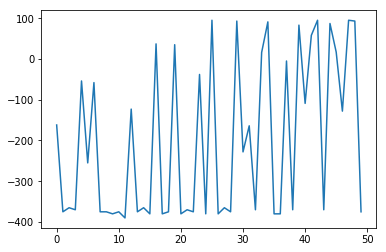

In [9]:
plt.plot(episode_rewards)

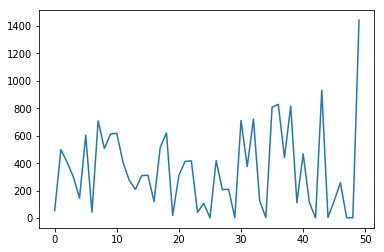

In [10]:
plt.plot(episode_losses)

In [11]:
game.close()

In [12]:
print(episode_rewards)

[-162.0, -375.0, -365.0, -370.0, -54.0, -255.0, -58.0, -375.0, -375.0, -380.0, -375.0, -390.0, -123.0, -375.0, -365.0, -380.0, 37.0, -380.0, -375.0, 35.0, -380.0, -370.0, -375.0, -38.0, -380.0, 95.0, -380.0, -365.0, -375.0, 93.0, -228.0, -164.0, -370.0, 16.0, 91.0, -380.0, -380.0, -5.0, -370.0, 83.0, -109.0, 58.0, 95.0, -370.0, 87.0, 17.0, -128.0, 95.0, 93.0, -375.0]
